# BERT-based News Topic Classifier

This notebook implements a complete ML pipeline for fine-tuning BERT on the AG News dataset for topic classification.

## Dataset Information
- **AG News Dataset**: Contains news headlines categorized into 4 topics
- **Classes**: World (0), Sports (1), Business (2), Science/Technology (3)
- **Size**: 120,000 training samples, 7,600 test samples

In [1]:
# Install required packages
!pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn joblib

You should consider upgrading via the 'C:\Users\karat\Downloads\NewsTopicBERT\news-env\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# Import necessary libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


## 1. Data Loading and Exploration

In [3]:
# Load the AG News dataset
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

print("Dataset loaded successfully!")
print(f"Train set size: {len(dataset['train'])}")
print(f"Test set size: {len(dataset['test'])}")

# Display dataset structure
print("\nDataset structure:")
print(dataset)

# Show sample data
print("\nSample training data:")
for i in range(3):
    sample = dataset['train'][i]
    print(f"Text: {sample['text'][:100]}...")
    print(f"Label: {sample['label']}\n")

Loading AG News dataset...
Dataset loaded successfully!
Train set size: 120000
Test set size: 7600

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Sample training data:
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\b...
Label: 2

Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,...
Label: 2

Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about th...
Label: 2



In [4]:
# Define class labels
class_names = ['World', 'Sports', 'Business', 'Science/Technology']
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Analyze class distribution
train_labels = [sample['label'] for sample in dataset['train']]
test_labels = [sample['label'] for sample in dataset['test']]

train_label_counts = pd.Series(train_labels).value_counts().sort_index()
test_label_counts = pd.Series(test_labels).value_counts().sort_index()

print("\nClass distribution in training set:")
for i, count in enumerate(train_label_counts):
    print(f"{class_names[i]}: {count} ({count/len(train_labels)*100:.1f}%)")

print("\nClass distribution in test set:")
for i, count in enumerate(test_label_counts):
    print(f"{class_names[i]}: {count} ({count/len(test_labels)*100:.1f}%)")

Number of classes: 4
Class names: ['World', 'Sports', 'Business', 'Science/Technology']

Class distribution in training set:
World: 30000 (25.0%)
Sports: 30000 (25.0%)
Business: 30000 (25.0%)
Science/Technology: 30000 (25.0%)

Class distribution in test set:
World: 1900 (25.0%)
Sports: 1900 (25.0%)
Business: 1900 (25.0%)
Science/Technology: 1900 (25.0%)


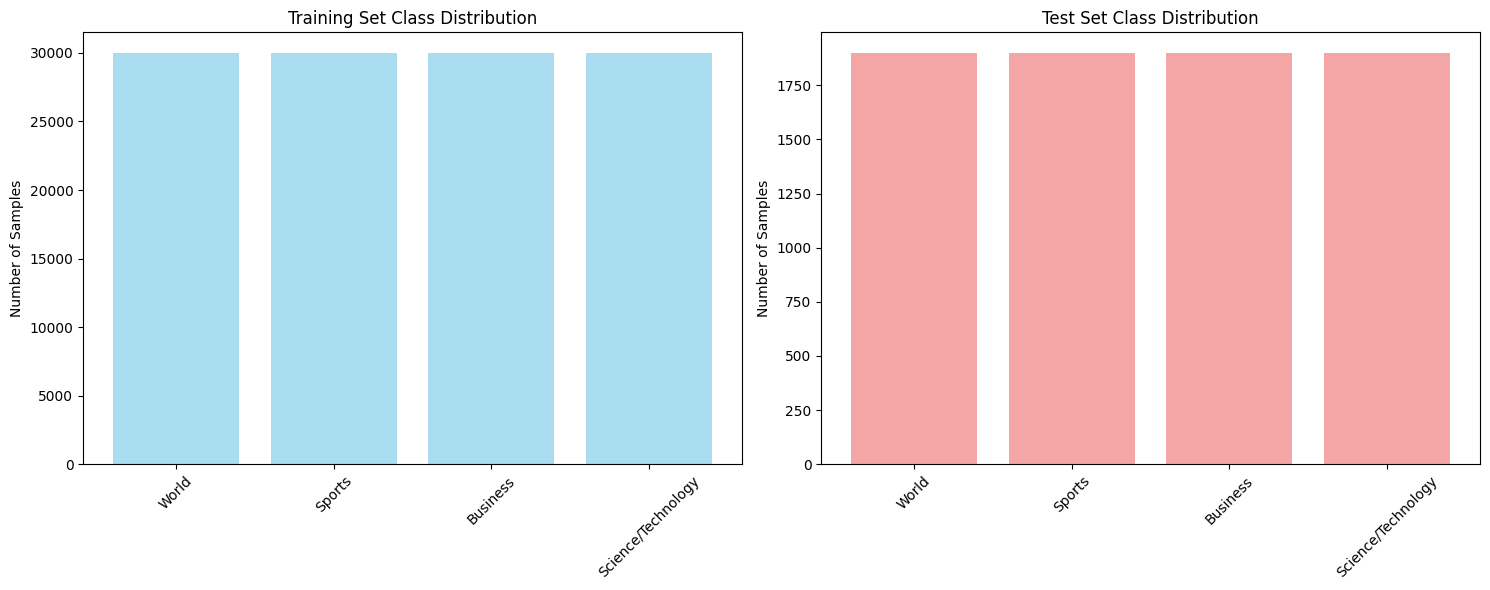


Text length statistics (training set):
Mean: 236.5
Median: 232.0
Max: 1012
Min: 100


In [5]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set distribution
ax1.bar(class_names, train_label_counts, color='skyblue', alpha=0.7)
ax1.set_title('Training Set Class Distribution')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)

# Test set distribution
ax2.bar(class_names, test_label_counts, color='lightcoral', alpha=0.7)
ax2.set_title('Test Set Class Distribution')
ax2.set_ylabel('Number of Samples')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Text length analysis
train_text_lengths = [len(sample['text']) for sample in dataset['train']]
test_text_lengths = [len(sample['text']) for sample in dataset['test']]

print(f"\nText length statistics (training set):")
print(f"Mean: {np.mean(train_text_lengths):.1f}")
print(f"Median: {np.median(train_text_lengths):.1f}")
print(f"Max: {np.max(train_text_lengths)}")
print(f"Min: {np.min(train_text_lengths)}")

## 2. Data Preprocessing and Tokenization

In [6]:
# Initialize tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Tokenizer loaded: {model_name}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

# Test tokenization on a sample
sample_text = dataset['train'][0]['text']
print(f"\nSample text: {sample_text}")

# Tokenize sample
tokens = tokenizer.tokenize(sample_text)
print(f"Tokens: {tokens[:10]}...")  # Show first 10 tokens
print(f"Number of tokens: {len(tokens)}")

# Encode sample
encoded = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print(f"\nEncoded input shape: {encoded['input_ids'].shape}")
print(f"Attention mask shape: {encoded['attention_mask'].shape}")

Tokenizer loaded: bert-base-uncased
Vocabulary size: 30522

Sample text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Tokens: ['wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(']...
Number of tokens: 39

Encoded input shape: torch.Size([1, 128])
Attention mask shape: torch.Size([1, 128])


Analyzing sequence lengths...


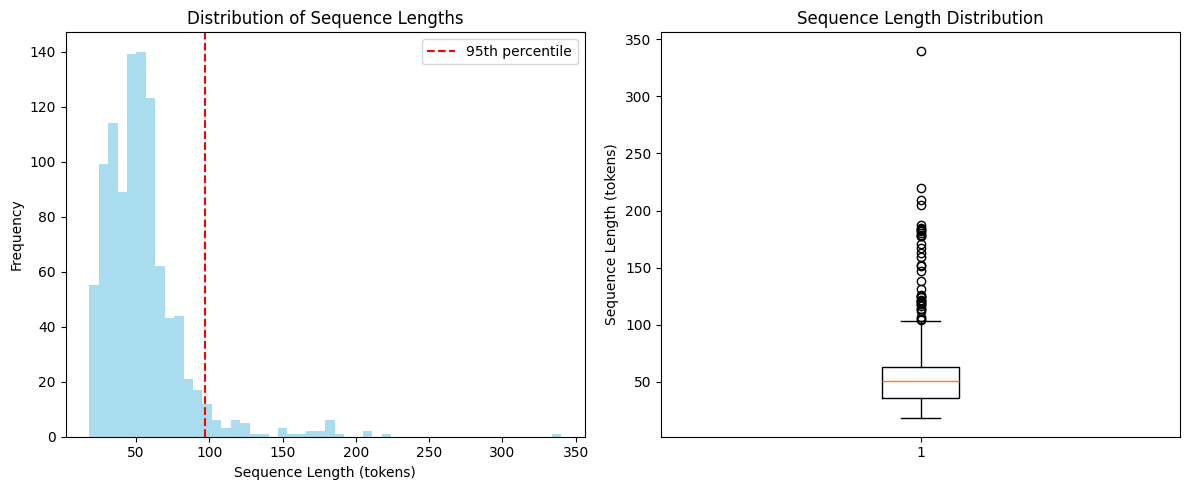

Sequence length statistics:
Mean: 54.3
Median: 51.0
95th percentile: 97.0
Max: 340

Chosen max_length: 107


In [7]:
# Analyze optimal sequence length
def analyze_sequence_lengths(dataset_split, tokenizer, max_samples=1000):
    """Analyze the distribution of sequence lengths after tokenization"""
    lengths = []
    
    for i, sample in enumerate(dataset_split):
        if i >= max_samples:
            break
        tokens = tokenizer.tokenize(sample['text'])
        lengths.append(len(tokens))
    
    return lengths

# Analyze sequence lengths
print("Analyzing sequence lengths...")
train_lengths = analyze_sequence_lengths(dataset['train'], tokenizer)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Sequence Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.axvline(np.percentile(train_lengths, 95), color='red', linestyle='--', label='95th percentile')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(train_lengths)
plt.ylabel('Sequence Length (tokens)')
plt.title('Sequence Length Distribution')

plt.tight_layout()
plt.show()

print(f"Sequence length statistics:")
print(f"Mean: {np.mean(train_lengths):.1f}")
print(f"Median: {np.median(train_lengths):.1f}")
print(f"95th percentile: {np.percentile(train_lengths, 95):.1f}")
print(f"Max: {np.max(train_lengths)}")

# Choose max_length based on 95th percentile
max_length = min(int(np.percentile(train_lengths, 95)) + 10, 512)
print(f"\nChosen max_length: {max_length}")

In [8]:
# Create custom Dataset class
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize and encode
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Prepare data
train_texts = [sample['text'] for sample in dataset['train']]
train_labels = [sample['label'] for sample in dataset['train']]
test_texts = [sample['text'] for sample in dataset['test']]
test_labels = [sample['label'] for sample in dataset['test']]

# Create train/validation split
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, 
    test_size=0.1, 
    random_state=42, 
    stratify=train_labels
)

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")

# Create datasets
train_dataset = AGNewsDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = AGNewsDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = AGNewsDataset(test_texts, test_labels, tokenizer, max_length)

print("\nDatasets created successfully!")
print(f"Sample from training dataset:")
sample = train_dataset[0]
for key, value in sample.items():
    print(f"{key}: {value.shape if hasattr(value, 'shape') else value}")

Training set size: 108000
Validation set size: 12000
Test set size: 7600

Datasets created successfully!
Sample from training dataset:
input_ids: torch.Size([107])
attention_mask: torch.Size([107])
labels: torch.Size([])


## 3. Model Setup and Fine-tuning

In [9]:
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    id2label={i: class_names[i] for i in range(num_classes)},
    label2id={class_names[i]: i for i in range(num_classes)}
)

print(f"Model loaded: {model_name}")
print(f"Number of parameters: {model.num_parameters():,}")

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: bert-base-uncased
Number of parameters: 109,485,316
Using device: cpu


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False,
    report_to=None  # Disable wandb logging
)

print("Training arguments configured:")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Batch size (train): {training_args.per_device_train_batch_size}")
print(f"Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"Learning rate: {training_args.learning_rate}")

Training arguments configured:
Epochs: 3
Batch size (train): 16
Batch size (eval): 16
Learning rate: 5e-05


In [11]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Trainer initialized successfully!")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Trainer initialized successfully!
Training dataset size: 108000
Validation dataset size: 12000


In [12]:
# Start training
print("Starting training...")
print("This may take several minutes depending on your hardware.")

# Train the model
trainer.train()

print("Training completed!")

Starting training...
This may take several minutes depending on your hardware.


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.285500,0.294214,0.907500,0.907507
1000,0.296300,0.264969,0.914417,0.913945
1500,0.291800,0.243001,0.922000,0.922013
2000,0.284500,0.234656,0.926500,0.926762
2500,0.240300,0.218232,0.929417,0.929167
3000,0.270400,0.242968,0.927500,0.927195
3500,0.219300,0.295568,0.918833,0.918524
4000,0.221100,0.201010,0.932667,0.932791
4500,0.205800,0.221716,0.929167,0.929224
5000,0.230300,0.194225,0.938500,0.938567


Training completed!


## 4. Model Evaluation

In [13]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_results = trainer.evaluate(eval_dataset=val_dataset)

print("\nValidation Results:")
for key, value in val_results.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '')
        print(f"{metric_name.capitalize()}: {value:.4f}")

Evaluating on validation set...



Validation Results:
Loss: 0.2277
Accuracy: 0.9444
F1: 0.9444
Runtime: 1131.1791
Samples_per_second: 10.6080
Steps_per_second: 0.6630


In [14]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)

print("\nTest Results:")
for key, value in test_results.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '')
        print(f"{metric_name.capitalize()}: {value:.4f}")

Evaluating on test set...

Test Results:
Loss: 0.2478
Accuracy: 0.9371
F1: 0.9371
Runtime: 758.4897
Samples_per_second: 10.0200
Steps_per_second: 0.6260


In [15]:
# Get detailed predictions for test set
print("Getting detailed predictions...")
test_predictions = trainer.predict(test_dataset)
test_pred_labels = np.argmax(test_predictions.predictions, axis=1)

# Calculate detailed metrics
test_accuracy = accuracy_score(test_labels, test_pred_labels)
test_f1_weighted = f1_score(test_labels, test_pred_labels, average='weighted')
test_f1_macro = f1_score(test_labels, test_pred_labels, average='macro')

print(f"\nDetailed Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-Score (Weighted): {test_f1_weighted:.4f}")
print(f"F1-Score (Macro): {test_f1_macro:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_pred_labels, target_names=class_names))

Getting detailed predictions...

Detailed Test Metrics:
Accuracy: 0.9371
F1-Score (Weighted): 0.9371
F1-Score (Macro): 0.9371

Classification Report:
                    precision    recall  f1-score   support

             World       0.95      0.94      0.95      1900
            Sports       0.98      0.99      0.98      1900
          Business       0.90      0.91      0.91      1900
Science/Technology       0.91      0.91      0.91      1900

          accuracy                           0.94      7600
         macro avg       0.94      0.94      0.94      7600
      weighted avg       0.94      0.94      0.94      7600



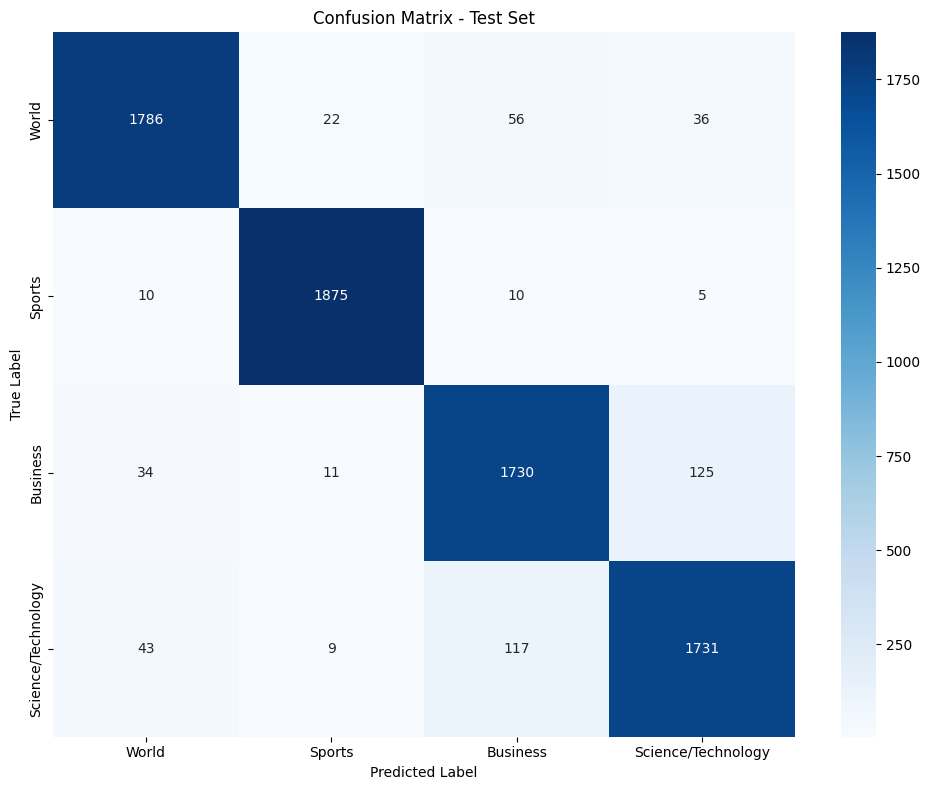


Per-class Accuracy:
World: 0.9400
Sports: 0.9868
Business: 0.9105
Science/Technology: 0.9111


In [16]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"{class_names[i]}: {acc:.4f}")

## 5. Model Testing and Examples

In [17]:
# Function to predict single text
def predict_text(text, model, tokenizer, device, max_length=128):
    """Predict the class of a single text"""
    model.eval()
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Get prediction and confidence
    predicted_class = torch.argmax(predictions, dim=-1).item()
    confidence = predictions[0][predicted_class].item()
    
    return predicted_class, confidence, predictions[0].cpu().numpy()

# Test with sample headlines
sample_headlines = [
    "Apple reports record quarterly earnings beating analyst expectations",
    "Scientists discover new exoplanet in habitable zone of distant star",
    "Manchester United defeats Liverpool 3-1 in Premier League match",
    "UN Security Council discusses escalating tensions in Middle East region",
    "New AI breakthrough could revolutionize medical diagnosis accuracy"
]

print("Testing model with sample headlines:")
print("="*70)

for headline in sample_headlines:
    pred_class, confidence, all_probs = predict_text(
        headline, model, tokenizer, device, max_length
    )
    
    print(f"\nHeadline: {headline}")
    print(f"Predicted: {class_names[pred_class]} (confidence: {confidence:.3f})")
    
    # Show all probabilities
    print("All probabilities:")
    for i, prob in enumerate(all_probs):
        print(f"  {class_names[i]}: {prob:.3f}")
    print("-" * 50)

Testing model with sample headlines:

Headline: Apple reports record quarterly earnings beating analyst expectations
Predicted: Business (confidence: 0.706)
All probabilities:
  World: 0.002
  Sports: 0.000
  Business: 0.706
  Science/Technology: 0.292
--------------------------------------------------

Headline: Scientists discover new exoplanet in habitable zone of distant star
Predicted: Science/Technology (confidence: 0.992)
All probabilities:
  World: 0.007
  Sports: 0.000
  Business: 0.001
  Science/Technology: 0.992
--------------------------------------------------

Headline: Manchester United defeats Liverpool 3-1 in Premier League match
Predicted: Sports (confidence: 0.993)
All probabilities:
  World: 0.006
  Sports: 0.993
  Business: 0.000
  Science/Technology: 0.000
--------------------------------------------------

Headline: UN Security Council discusses escalating tensions in Middle East region
Predicted: World (confidence: 0.999)
All probabilities:
  World: 0.999
  Spor

## 6. Model Saving

In [18]:
# Create model directory
model_dir = "./fine_tuned_bert_agnews"
os.makedirs(model_dir, exist_ok=True)

# Save the fine-tuned model and tokenizer
print("Saving fine-tuned model...")
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

# Save additional metadata
metadata = {
    'class_names': class_names,
    'num_classes': num_classes,
    'max_length': max_length,
    'model_name': model_name,
    'test_accuracy': test_accuracy,
    'test_f1_weighted': test_f1_weighted,
    'test_f1_macro': test_f1_macro
}

joblib.dump(metadata, os.path.join(model_dir, 'metadata.joblib'))

print(f"Model saved to: {model_dir}")
print(f"Files saved:")
for file in os.listdir(model_dir):
    print(f"  - {file}")

print("\nModel is ready for deployment!")

Saving fine-tuned model...
Model saved to: ./fine_tuned_bert_agnews
Files saved:
  - config.json
  - metadata.joblib
  - model.safetensors
  - special_tokens_map.json
  - tokenizer.json
  - tokenizer_config.json
  - vocab.txt

Model is ready for deployment!


## 7. Training Summary and Visualizations

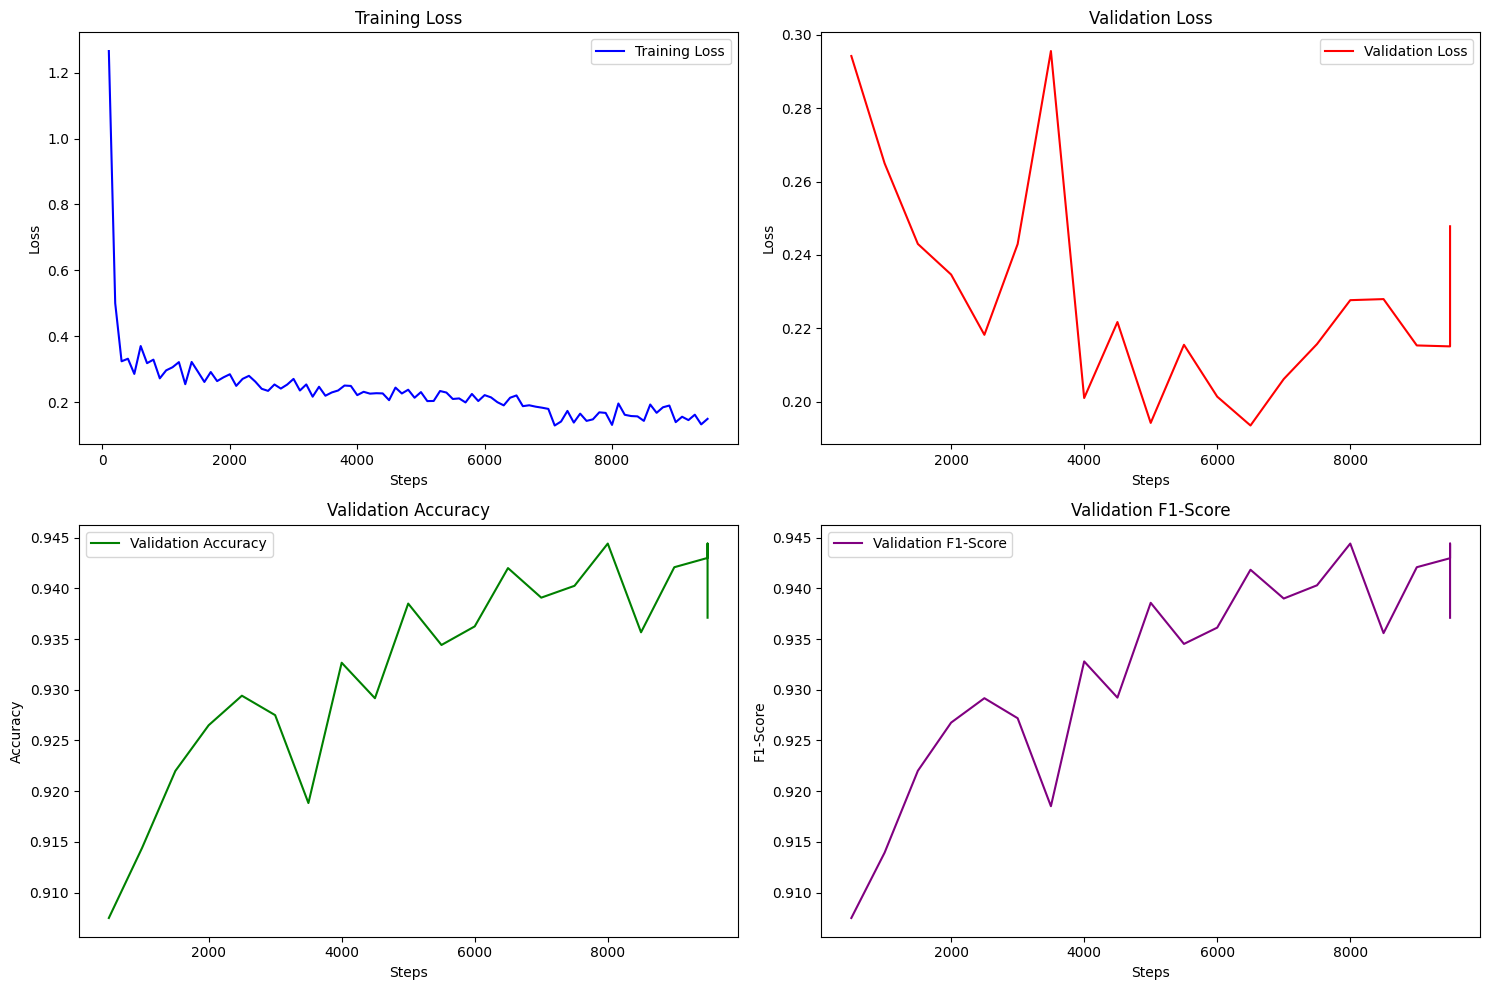

In [19]:
# Plot training history if available
if hasattr(trainer.state, 'log_history') and trainer.state.log_history:
    logs = trainer.state.log_history
    
    # Extract training and evaluation metrics
    train_steps = []
    train_loss = []
    eval_steps = []
    eval_loss = []
    eval_accuracy = []
    eval_f1 = []
    
    for log in logs:
        if 'loss' in log and 'step' in log:
            train_steps.append(log['step'])
            train_loss.append(log['loss'])
        if 'eval_loss' in log and 'step' in log:
            eval_steps.append(log['step'])
            eval_loss.append(log['eval_loss'])
            eval_accuracy.append(log.get('eval_accuracy', 0))
            eval_f1.append(log.get('eval_f1', 0))
    
    if train_steps and eval_steps:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Training loss
        ax1.plot(train_steps, train_loss, 'b-', label='Training Loss')
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss')
        ax1.legend()
        
        # Evaluation loss
        ax2.plot(eval_steps, eval_loss, 'r-', label='Validation Loss')
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('Loss')
        ax2.set_title('Validation Loss')
        ax2.legend()
        
        # Evaluation accuracy
        ax3.plot(eval_steps, eval_accuracy, 'g-', label='Validation Accuracy')
        ax3.set_xlabel('Steps')
        ax3.set_ylabel('Accuracy')
        ax3.set_title('Validation Accuracy')
        ax3.legend()
        
        # Evaluation F1-score
        ax4.plot(eval_steps, eval_f1, 'purple', label='Validation F1-Score')
        ax4.set_xlabel('Steps')
        ax4.set_ylabel('F1-Score')
        ax4.set_title('Validation F1-Score')
        ax4.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("Training history not available for plotting.")
else:
    print("Training history not available.")

In [20]:
# Final summary
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"Model: {model_name}")
print(f"Dataset: AG News (4 classes)")
print(f"Classes: {', '.join(class_names)}")
print(f"Training samples: {len(train_texts):,}")
print(f"Validation samples: {len(val_texts):,}")
print(f"Test samples: {len(test_texts):,}")
print(f"Max sequence length: {max_length}")
print(f"Training epochs: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print("\nFINAL TEST RESULTS:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-Score (Weighted): {test_f1_weighted:.4f}")
print(f"F1-Score (Macro): {test_f1_macro:.4f}")
print(f"\nModel saved to: {model_dir}")
print("Ready for Streamlit deployment!")
print("="*70)


TRAINING SUMMARY
Model: bert-base-uncased
Dataset: AG News (4 classes)
Classes: World, Sports, Business, Science/Technology
Training samples: 108,000
Validation samples: 12,000
Test samples: 7,600
Max sequence length: 107
Training epochs: 3
Batch size: 16

FINAL TEST RESULTS:
Accuracy: 0.9371
F1-Score (Weighted): 0.9371
F1-Score (Macro): 0.9371

Model saved to: ./fine_tuned_bert_agnews
Ready for Streamlit deployment!
